# LinkedIn


## Setup


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

## Data


In [2]:
# Dataset: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024

job_skills_df = pd.read_csv("./data/job_skills.csv")
job_summaries_df = pd.read_csv("./data/job_summaries.csv")
job_postings_df = pd.read_csv("./data/job_postings.csv")

In [3]:
jobs_df = job_postings_df[
    [
        "job_title",
        "company",
        "job_location",
        "search_city",
        "search_country",
        "search_position",
        "job_level",
        "job_type",
        "first_seen",
        "last_processed_time",
        "job_link",
    ]
]

In [4]:
skills_df = job_skills_df[["job_link"]]
skills_df["job_skills"] = job_skills_df["job_skills"].str.split(", ")
skills_df = skills_df.set_index("job_link").explode("job_skills")

In [5]:
company_job_openings = jobs_df["company"].value_counts()

## Questions


### What companies have the most job openings?


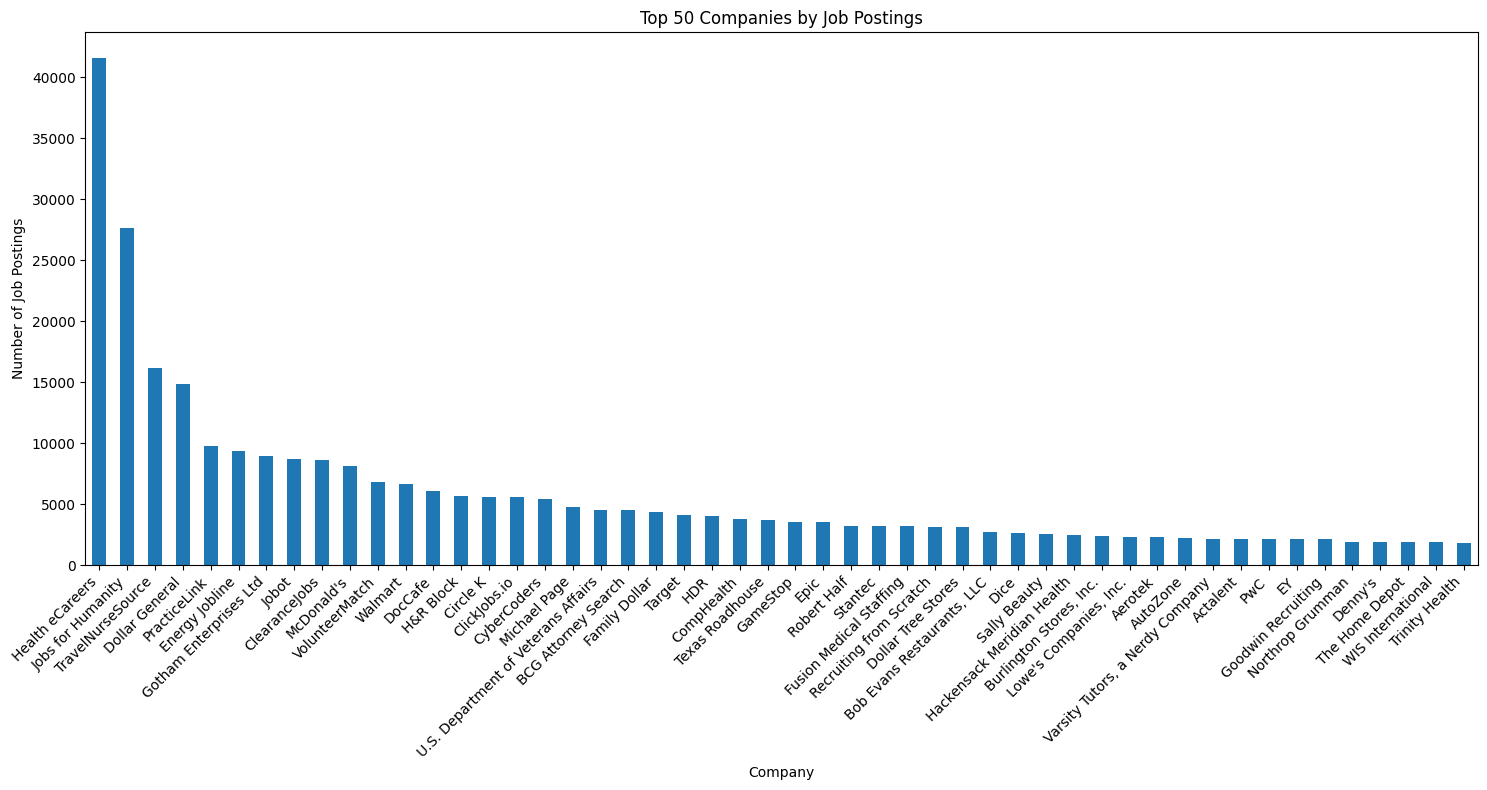

In [10]:
top_50_companies = company_job_openings.head(50)
plt.figure(figsize=(15, 8))
top_50_companies.plot(kind="bar")
plt.title("Top 50 Companies by Job Postings")
plt.xlabel("Company")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### What are the most requested job levels?


### What are the most requested job titles?
